In [ ]:
# Cell 1: Imports and Setup
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Basic Scanpy settings
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

# --- *** PATHS *** ---
# Path to the directory containing matrix.mtx.gz, barcodes.tsv.gz, features.tsv.gz
data_dir = r'C:\Users\Qiang\OneDrive\Desktop\shenzhen Uui\project\circular_RNA\code\filtered_feature_bc_matrix_SRR32798896_filtereddata'

# Path to the directory where output files (plots, .h5ad) will be saved
# Use the exact path provided
output_dir = r'C:\Users\Qiang\OneDrive\Desktop\shenzhen Uui\project\circular_RNA\code\filtered_feature_bc_matrix_SRR32798896_filtereddata_ratio_newfilter_celltypist_dynamics'

# Prefix for output files (optional - helps distinguish files if you analyze multiple samples)
output_prefix = 'WT_sample_analysis'
# --- ************* ---

# Note: os.makedirs won't raise an error if the directory already exists
os.makedirs(output_dir, exist_ok=True)
# Set Scanpy's figure directory to the desired output directory
sc.settings.figdir = output_dir

print(f"Using Scanpy version {sc.__version__}")
print(f"Data directory: {os.path.abspath(data_dir)}")
print(f"Output directory: {os.path.abspath(output_dir)}") # This should now print your 'code' directory path


In [ ]:
# Cell 2: Load Data (Step a)
print("\n--- Step a: Loading Data ---")
# Check if the directory exists before trying to read
if not os.path.isdir(data_dir):
    raise FileNotFoundError(f"Data directory not found: {data_dir}. Please check the path in Cell 1.")

adata = sc.read_10x_mtx(
    data_dir,                  # the directory with the data files (defined in Cell 1)
    var_names='gene_symbols',  # use gene symbols for the variable names (variables-axis index)
    cache=True)                # write a cache file for faster subsequent reading

adata.var_names_make_unique()  # Ensure gene names are unique

print(f"Loaded AnnData object: {adata}")
print(f"N cells: {adata.n_obs}, N genes: {adata.n_vars}")

# Store raw counts in a layer for downstream use (e.g., differential expression)
adata.layers["counts"] = adata.X.copy()


In [ ]:
# Cell 3: Calculate QC Metrics (Step b.1)
print("\n--- Step b: Quality Control and Filtering ---")
print("Calculating QC metrics...")

# Identify mitochondrial genes.
# *** Important: Adjust prefix if needed! 'mt-' for mouse, 'MT-' for human usually. ***
# Double-check your features.tsv.gz if unsure.
mito_prefix = 'mt-' # Assuming mouse based on 'musWT' prefix earlier. Change if human.
adata.var['mt'] = adata.var_names.str.startswith(mito_prefix)

# Calculate QC metrics using Scanpy's function
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

print("QC metrics calculated:")
print(adata.obs.head()) # Show first few rows of observation metadata including QC
print(adata.var.head()) # Show first few rows of variable metadata including QC


In [ ]:
# Cell 4: Visualize QC Metrics (Step b.2) - Interactive Part!
print("Visualizing QC metrics (before filtering)...")

# Use Scanpy plotting functions (plots will appear below the cell and be saved)
fig, axs = plt.subplots(1, 4, figsize=(18, 4))
# Note: save paths are relative to sc.settings.figdir defined in Cell 1
sc.pl.violin(adata, 'n_genes_by_counts', jitter=0.4, multi_panel=False, ax=axs[0], show=False)
sc.pl.violin(adata, 'total_counts', jitter=0.4, multi_panel=False, ax=axs[1], show=False)
sc.pl.violin(adata, 'pct_counts_mt', jitter=0.4, multi_panel=False, ax=axs[2], show=False)

# Scatter plot: total counts vs n_genes, colored by mito percentage
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', color='pct_counts_mt', ax=axs[3], show=False)

plt.tight_layout()
# Construct the full save path using os.path.join
save_path_qc_before = os.path.join(output_dir, f"{output_prefix}_qc_plots_before_filtering.png")
print(f"Saving QC plots (before filtering) to: {save_path_qc_before}")
plt.savefig(save_path_qc_before)
plt.show() # Display the plot inline in the notebook

# Optional: Plot highest expressed genes
# sc.pl.highest_expr_genes(adata, n_top=20, save=f"_{output_prefix}_highest_expr_genes.png")
# plt.show()


In [ ]:
# Cell 5: Define and Apply Filters (Step b.3 & b.4)
# --- *** DEFINE FILTERING THRESHOLDS BASED ON PLOTS ABOVE (Cell 4) *** ---

# These are EXAMPLES - adjust them based on your data's distributions! old version
min_genes_per_cell = 200     # Filter cells with fewer than this many genes detected
max_genes_per_cell = 7000    # Filter cells with more genes (potential doublets/multiplets)
max_pct_counts_mt = 10       # Filter cells with > this % mitochondrial counts (stressed/dying)
min_cells_per_gene = 3       # Filter genes expressed in fewer than this many cells
# --- ***************************************************************** ---

# These are EXAMPLES - adjust them based on your data's distributions!
# min_genes_per_cell = 3000     # Filter cells with fewer than this many genes detected
# max_genes_per_cell = 5000    # Filter cells with more genes (potential doublets/multiplets)
# max_pct_counts_mt = 5       # Filter cells with > this % mitochondrial counts (stressed/dying)
# min_cells_per_gene = 50       # Filter genes expressed in fewer than this many cells
# --- ***************************************************************** ---

print(f"Applying filters with thresholds:")
print(f"  min_genes_per_cell: {min_genes_per_cell}")
print(f"  max_genes_per_cell: {max_genes_per_cell}")
print(f"  max_pct_counts_mt: {max_pct_counts_mt}")
print(f"  min_cells_per_gene: {min_cells_per_gene}")

# Store original dimensions before filtering
n_cells_orig, n_genes_orig = adata.shape
print(f"Original dimensions: {n_cells_orig} cells, {n_genes_orig} genes")

# Apply Filters step-by-step to see the effect (optional)
# sc.pp.filter_cells(adata, min_genes=min_genes_per_cell)
# print(f"After min_genes filter: {adata.n_obs} cells")
# sc.pp.filter_cells(adata, max_genes=max_genes_per_cell)
# print(f"After max_genes filter: {adata.n_obs} cells")
# adata_pre_mito = adata.copy() # Keep track before mito filtering if needed
# adata = adata[adata.obs.pct_counts_mt < max_pct_counts_mt, :]
# print(f"After pct_counts_mt filter: {adata.n_obs} cells")
# sc.pp.filter_genes(adata, min_cells=min_cells_per_gene)
# print(f"After min_cells_per_gene filter: {adata.n_vars} genes")

# Apply filters (concise version)
adata_pre_filter = adata.copy() # Keep original object if needed
sc.pp.filter_cells(adata, min_genes=min_genes_per_cell)
sc.pp.filter_cells(adata, max_genes=max_genes_per_cell)
adata = adata[adata.obs.pct_counts_mt < max_pct_counts_mt, :]
sc.pp.filter_genes(adata, min_cells=min_cells_per_gene)


print(f"Finished filtering.")
print(f"Filtered dimensions: {adata.n_obs} cells, {adata.n_vars} genes")
if n_cells_orig > 0:
    print(f"Retained {adata.n_obs / n_cells_orig * 100:.2f}% of cells")
if n_genes_orig > 0:
    print(f"Retained {adata.n_vars / n_genes_orig * 100:.2f}% of genes")

# Optional: Visualize QC metrics AFTER filtering to confirm effect
# fig, axs = plt.subplots(1, 4, figsize=(18, 4))
# sc.pl.violin(adata, 'n_genes_by_counts', jitter=0.4, multi_panel=False, ax=axs[0], show=False)
# sc.pl.violin(adata, 'total_counts', jitter=0.4, multi_panel=False, ax=axs[1], show=False)
# sc.pl.violin(adata, 'pct_counts_mt', jitter=0.4, multi_panel=False, ax=axs[2], show=False)
# sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', color='pct_counts_mt', ax=axs[3], show=False)
# plt.tight_layout()
# save_path_qc_after = os.path.join(output_dir, f"{output_prefix}_qc_plots_after_filtering.png")
# print(f"Saving QC plots (after filtering) to: {save_path_qc_after}")
# plt.savefig(save_path_qc_after)
# plt.show()


In [ ]:
# Cell 6: Normalization (Step c)
print("\n--- Step c: Normalization ---")
# Normalize counts per cell to a target sum (library size scaling)
# Each cell will appear to have the same total count (e.g., 10,000)
sc.pp.normalize_total(adata, target_sum=1e4)

# Log-transform the normalized data (stabilizes variance)
# Adds 1 before logging to avoid log(0) issues (log1p = log(1+x))
sc.pp.log1p(adata)

print("Normalization (library size) and log-transformation complete.")
# Display some example values from the normalized+log-transformed matrix
if adata.n_obs > 0 and adata.n_vars > 0:
    print(f"Example data point after normalization/log: {adata.X[0, :min(10, adata.n_vars)]}")


In [ ]:
# Cell 7: Identify Highly Variable Genes (HVGs) (Step d)
print("\n--- Step d: Identify Highly Variable Genes ---")
# Store the normalized, log-transformed data in adata.raw before filtering to HVGs
# This allows using all genes later for marker analysis or visualization if needed
adata.raw = adata.copy()

# Identify highly variable genes based on dispersion relative to mean expression
# Default parameters often work well, but you can adjust min_mean, max_mean, min_disp
# n_top_genes can also be used instead of mean/dispersion thresholds
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
# Alternative: sc.pp.highly_variable_genes(adata, n_top_genes=2000)

print(f"Identified {adata.var.highly_variable.sum()} highly variable genes.")

# Plot HVGs to visualize selection
# Note: The save argument uses the prefix and saves relative to figdir
sc.pl.highly_variable_genes(adata, save=f"_{output_prefix}_hvg_plot.png")
plt.show() # Ensure plot is shown inline

# Filter the AnnData object's main matrix (.X) to keep only HVGs
# Downstream steps like PCA and clustering will typically only use these genes
adata = adata[:, adata.var.highly_variable]
print(f"AnnData object subsetted to HVGs: {adata.shape}")


In [ ]:
# Cell 8: Scale Data (Step e)
print("\n--- Step e: Scaling Data ---")
# Scale data to zero mean and unit variance *across cells* for each gene.
# This gives all genes equal weight in downstream analyses like PCA.
# Clipping values prevents extreme outliers from dominating.
sc.pp.scale(adata, max_value=10)

print("Data scaled (each gene: mean 0, variance 1).")
# Display some example values from the scaled matrix
if adata.n_obs > 0 and adata.n_vars > 0:
    print(f"Example data point after scaling: {adata.X[0, :min(10, adata.n_vars)]}")


In [ ]:
# Cell 9: Principal Component Analysis (PCA) (Step f)
print("\n--- Step f: Principal Component Analysis (PCA) ---")
# Run PCA on the scaled HVG data
# n_comps is the number of principal components to compute (usually 50 is sufficient)
sc.tl.pca(adata, svd_solver='arpack', n_comps=50)

print("PCA calculation complete.")

# Visualize the results: Plot PCA variance ratio (elbow plot)
# Helps decide how many PCs capture significant biological variance vs noise
# Look for the 'elbow' point where the curve flattens
sc.pl.pca_variance_ratio(adata, log=True, n_pcs=50, save=f"_{output_prefix}_pca_variance.png")
plt.show()

# Optional: Scatter plot of first few PCs colored by QC metrics or expected batch effects
# sc.pl.pca(adata, color=['total_counts', 'pct_counts_mt'], components=['1,2', '3,4'],
#           save=f"_{output_prefix}_pca_scatter_qc.png")
# plt.show()


In [ ]:
# Cell 10: Compute Neighborhood Graph (Step g.1)
# --- *** DEFINE NUMBER OF PCs based on Elbow Plot (Cell 9) *** ---
# Choose the number of PCs that seem to capture the main variance before the curve flattens
n_pcs_to_use = 20 # Example: Adjust based on your PCA variance plot!
# --- ********************************************************* ---

print(f"\n--- Step g: Clustering ---")
print(f"Computing neighborhood graph using the top {n_pcs_to_use} PCs...")

# Compute neighborhood graph (find nearest neighbors in PCA space)
# n_neighbors determines local structure smoothness (default 15 is often good)
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=n_pcs_to_use)

print("Neighborhood graph computed.")


In [ ]:
# Cell 11: Clustering (Leiden Algorithm) (Step g.2)
# --- *** DEFINE CLUSTERING RESOLUTION *** ---
# This parameter controls the granularity of the clustering.
# Higher resolution -> more clusters, Lower resolution -> fewer clusters.
# Often requires trying a few values (e.g., 0.4, 0.6, 0.8, 1.0) and seeing the results on UMAP.
clustering_resolution = 0.6 # Example: Start with a moderate value
# --- ********************************** ---

print(f"Running Leiden clustering with resolution {clustering_resolution}...")

# Run Leiden clustering algorithm on the neighborhood graph
# Results are stored in adata.obs['leiden']
sc.tl.leiden(adata, resolution=clustering_resolution)

print("Leiden clustering complete.")
print("Cluster counts:")
# Show how many cells are in each cluster
print(adata.obs['leiden'].value_counts().sort_index())


In [ ]:
# Cell 12: Visualization (UMAP) (Step h)
print("\n--- Step h: Visualization (UMAP) ---")
print("Computing UMAP embedding...")

# Compute UMAP (Uniform Manifold Approximation and Projection) based on the neighborhood graph
# This reduces the dimensionality further (usually to 2D) for visualization
sc.tl.umap(adata)

print("UMAP computation complete.")

# Plot UMAP colored by Leiden clusters
# Check if the clusters look reasonably separated. If not, revisit n_pcs or resolution.
sc.pl.umap(adata, color='leiden', legend_loc='on data',
          title=f'Leiden Clusters (res={clustering_resolution}, nPCs={n_pcs_to_use})',
          save=f"_{output_prefix}_umap_leiden_res{clustering_resolution}_pcs{n_pcs_to_use}.png")
plt.show()

# Optional: Plot UMAP colored by other QC features or potential marker genes
# Useful for checking if clusters correlate with technical factors or known biology
# sc.pl.umap(adata, color=['total_counts', 'n_genes_by_counts', 'pct_counts_mt'],
#           save=f"_{output_prefix}_umap_qc.png")
# plt.show()

# Example: Plot a known marker gene (replace 'GeneName' with an actual gene symbol)
# if 'GeneName' in adata.raw.var_names: # Check if gene exists in raw data
#     sc.pl.umap(adata, color='GeneName', use_raw=True,
#               save=f"_{output_prefix}_umap_marker_GeneName.png")
#     plt.show()
# else:
#     print("Marker gene 'GeneName' not found in adata.raw.var_names")


In [ ]:
# Cell 13: Annotate with CellTypist (Developing_Mouse_Brain) and plot UMAP
print("\n--- Step i: Cell Type Annotation with CellTypist ---")
import celltypist
from celltypist import annotate, models
import matplotlib.pyplot as plt
import os
import scanpy as sc # Ensure scanpy is imported if not already
import pandas as pd # Ensure pandas is imported if not already

# --- Configuration & Setup ---
# Ensure output_dir and output_prefix are defined from Cell 1
if 'output_dir' not in locals() or 'output_prefix' not in locals():
    raise NameError("Variables 'output_dir' and 'output_prefix' are not defined. Please run Cell 1 first.")
if 'adata' not in locals():
     raise NameError("Variable 'adata' is not defined. Please run previous cells first.")

# Set Scanpy figure directory if not already set (usually done in Cell 1)
sc.settings.figdir = output_dir

# 1) Set the path to the manually downloaded model
# <<< NOTE: You switched back to Mouse_Whole_Brain.pkl in your last code block >>>
model_name = 'Mouse_Whole_Brain.pkl' # Or 'Developing_Mouse_Brain.pkl' if you switched back
model_base_dir = r'C:\Users\Qiang\OneDrive\Desktop\shenzhen Uui\project\circular_RNA\code'
model_path = os.path.join(model_base_dir, model_name)

# 2) Verify and Load the model
if not os.path.exists(model_path):
    raise FileNotFoundError(f"Model file not found at {model_path}.")
else:
    print(f"Loading CellTypist model from: {model_path}")

try:
    model = models.Model.load(model_path)
    print("CellTypist model loaded successfully.")
except Exception as e:
    print(f"Error loading CellTypist model: {e}")
    raise e

# 3) Annotate each cell using CellTypist
print("Running CellTypist annotation...")
try:
    # Assuming 'majority_voting=True' requires pre-computed neighbors (from Cell 10)
    # Ensure adata.obsp['connectivities'] exists if using majority_voting=True
    if 'connectivities' not in adata.obsp:
         print("Warning: adata.obsp['connectivities'] not found. Cannot use majority_voting=True effectively. Running without it.")
         preds = annotate(adata, model=model, mode='best match')
    else:
         preds = annotate(adata, model=model, majority_voting=True, mode='best match')
    print("CellTypist annotation complete.")
except Exception as e:
    print(f"Error during CellTypist annotation: {e}")
    raise e

# 4) Inspect the structure of preds and store results
print("\nInspecting columns in preds.predicted_labels DataFrame:")
if hasattr(preds, 'predicted_labels') and isinstance(preds.predicted_labels, pd.DataFrame):
    print("Available columns:", list(preds.predicted_labels.columns))
    # print("\nFirst few rows of preds.predicted_labels:") # Optional: uncomment to see head
    # print(preds.predicted_labels.head())
else:
    print("Could not access preds.predicted_labels as a DataFrame.")
    print("\nAttributes available in 'preds' object:", dir(preds))
    raise AttributeError("Expected preds.predicted_labels to be a DataFrame, but it wasn't.")

# --- Store Labels ---
# Use 'majority_voting' column if available and majority_voting=True was used, otherwise 'predicted_labels'
label_col_to_use = 'predicted_labels' # Default
if 'majority_voting' in preds.predicted_labels.columns:
    label_col_to_use = 'majority_voting'
    print(f"Using '{label_col_to_use}' column for final labels.")
elif 'predicted_labels' in preds.predicted_labels.columns:
    print(f"Using '{label_col_to_use}' column for final labels.")
else:
    raise KeyError("Neither 'majority_voting' nor 'predicted_labels' column found in annotation results.")

adata.obs['ctpt_label'] = preds.predicted_labels[label_col_to_use].astype('category')
print("Stored CellTypist labels in adata.obs['ctpt_label'].")
print("\nExample predicted labels (Top 10):")
print(adata.obs['ctpt_label'].value_counts().nlargest(10))


# --- Store Confidence (Attempt) ---
# Try to find and store confidence scores, adjust column name as needed based on inspection output
confidence_col_found = None
potential_conf_cols = ['conf_score', 'scores', 'confidence', 'probability'] # Add others if needed

for col in potential_conf_cols:
    if col in preds.predicted_labels.columns:
        confidence_col_found = col
        print(f"Found potential confidence scores in column: '{confidence_col_found}'")
        break # Use the first one found

if confidence_col_found:
    adata.obs['ctpt_confidence'] = preds.predicted_labels[confidence_col_found]
    print(f"Stored confidence scores in adata.obs['ctpt_confidence'].")
    print("\nSummary statistics for confidence scores:")
    print(adata.obs['ctpt_confidence'].describe())
else:
     # Check alternative locations if necessary (less common)
     if hasattr(preds, 'confidence'):
         print("\nConfidence scores found directly in preds.confidence")
         # Handle potential format differences (e.g., numpy array vs Series)
         try:
             # Ensure index alignment when assigning from numpy array
             adata.obs['ctpt_confidence'] = pd.Series(preds.confidence, index=adata.obs.index)
             print("Stored confidence scores in adata.obs['ctpt_confidence'].")
             print(adata.obs['ctpt_confidence'].describe())
             confidence_col_found = True # Mark as found
         except Exception as e:
             print(f"Error processing preds.confidence: {e}")
             confidence_col_found = False
     else:
        print("\nCould not automatically find confidence score column in results.")
        confidence_col_found = False


# --- Plotting ---

# 5) Plot UMAP with CellTypist labels (Legend in Right Margin)
print("\nPlotting UMAP colored by CellTypist labels (Legend Aside)...")
sc.pl.umap(
    adata,
    color='ctpt_label',          # Use the stored labels
    legend_loc='right margin',   # Place legend outside plot area
    title=f'CellTypist Labels ({os.path.basename(model_path)})',
    legend_fontsize=8,           # Adjust font size as needed
    show=False,                  # Do not show immediately
    save=f"_{output_prefix}_celltypist_labels_legend_aside.png" # Save directly using scanpy
)
plt.show() # Display the plot inline after saving


# 6) (Optional) Plot UMAP with CellTypist confidence scores if found
if confidence_col_found:
    print("\nPlotting UMAP colored by CellTypist confidence scores...")
    sc.pl.umap(
        adata,
        color='ctpt_confidence',   # Color by the confidence score
        cmap='viridis',            # Use a sequential colormap
        title='CellTypist Confidence Score',
        show=False,
        save=f"_{output_prefix}_celltypist_confidence_umap.png"
    )
    plt.show()
else:
    print("\nSkipping confidence score plot as scores were not found/stored.")


# 7) (Optional but Recommended) Assign one label per Leiden cluster
print("\nAssigning consensus CellTypist label per Leiden cluster...")
if 'leiden' in adata.obs.columns: # Check if Leiden clustering was performed
    try:
        # Ensure 'leiden' is categorical
        if not pd.api.types.is_categorical_dtype(adata.obs['leiden']):
             adata.obs['leiden'] = adata.obs['leiden'].astype('category')

        cluster2label = (
            adata.obs
            .groupby('leiden')['ctpt_label'] # Group by Leiden cluster ID
            .agg(lambda x: x.value_counts().idxmax() if not x.empty else 'Unknown') # Find the most frequent CellTypist label
            .to_dict() # Convert to dictionary {cluster_id: label}
        )
        # Map the consensus label back to each cell based on its Leiden cluster
        adata.obs['cluster_ctpt'] = adata.obs['leiden'].map(cluster2label).astype('category') # Ensure categorical for plotting
        print("Consensus labels assigned to 'cluster_ctpt' in adata.obs.")

        # Plot UMAP with the consensus cluster labels (Legend Aside)
        print("Plotting UMAP colored by consensus cluster labels (Legend Aside)...")
        sc.pl.umap(
            adata,
            color='cluster_ctpt',       # Color by the new consensus cluster labels
            legend_loc='right margin',  # Legend outside plot area
            legend_fontsize=8,
            title='Cluster-level CellTypist Annotation',
            show=False,
            save=f"_{output_prefix}_cluster_celltypist_umap_legend_aside.png"
        )
        plt.show()
    except Exception as e:
        print(f"Error during cluster-level annotation or plotting: {e}")
else:
    print("Skipping cluster-level consensus annotation because 'leiden' column not found in adata.obs.")


# --- *** NEW STEP 7b: Export Annotations to CSV *** ---
print("\nExporting CellTypist annotations to CSV...")

# Define columns to export (Barcode is the index)
columns_to_export = []
if 'ctpt_label' in adata.obs.columns:
    columns_to_export.append('ctpt_label')
else:
    print("Warning: 'ctpt_label' column not found. Cannot export main CellTypist labels.")

# Optionally add confidence if it exists and was stored
if 'ctpt_confidence' in adata.obs.columns:
    columns_to_export.append('ctpt_confidence')

# Optionally add cluster consensus label if it exists
if 'cluster_ctpt' in adata.obs.columns:
     columns_to_export.append('cluster_ctpt')

if not columns_to_export:
    print("No CellTypist annotation columns found in adata.obs to export. Skipping CSV export.")
else:
    # Define the output CSV filename using the prefix from Cell 1
    csv_filename = f"{output_prefix}_celltypist_barcodes_celltypes.csv"
    csv_output_path = os.path.join(output_dir, csv_filename)

    try:
        # Select the data (index contains the cell barcodes)
        output_df = adata.obs[columns_to_export]

        # Export to CSV, including the index (barcodes) and header
        output_df.to_csv(csv_output_path, index=True, header=True)
        print(f"Successfully exported annotations to: {csv_output_path}")

    except Exception as e:
        print(f"Error exporting annotations to CSV '{csv_output_path}': {e}")
# --- *** END OF NEW STEP *** ---


# 8) Save the final AnnData object with CellTypist annotations
final_adata_path = os.path.join(output_dir, f"{output_prefix}_final_with_celltypist.h5ad")
print(f"\nSaving final annotated AnnData object to: {final_adata_path}")
try:
    adata.write(final_adata_path)
    print("Final AnnData object saved successfully.")
except Exception as e:
    print(f"Error saving final AnnData object: {e}")


In [ ]:
# Cell 14: Finding Marker Genes (Step i)
print("\n--- Step i: Finding Marker Genes ---")
print("Finding marker genes for each cluster (Wilcoxon rank-sum test)...")

# Find marker genes for each cluster compared to all other cells
# method='wilcoxon' is common and robust. 't-test' is another option.
# use_raw=True uses the log-normalized data from adata.raw (all genes)
# layer='counts' can be used to test on raw counts directly (may need library size adjustment)
# key_added specifies where the results are stored in adata.uns
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon', use_raw=True, key_added = "wilcoxon_rank_genes")

print("Marker gene calculation complete.")

# Plot top marker genes per cluster as a heatmap
# Shows the relative expression of the top N genes defining each cluster
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, key="wilcoxon_rank_genes",
                       save=f"_{output_prefix}_marker_genes_heatmap.png")
plt.show()

# Optional: Show top markers as a table
marker_results = pd.DataFrame(adata.uns['wilcoxon_rank_genes']['names']).head(10)
print("\nTop 10 marker genes per cluster (names):")
print(marker_results)
# You can save the full marker gene lists to a CSV file for exploration
# Example: Get results for cluster '0'
# results_df = sc.get.rank_genes_groups_df(adata, group="0", key="wilcoxon_rank_genes")
# print(results_df.head())
# Save all results
# all_markers_df = sc.get.rank_genes_groups_df(adata, group=None, key="wilcoxon_rank_genes")
# all_markers_path = os.path.join(output_dir, f"{output_prefix}_all_markers_wilcoxon.csv")
# all_markers_df.to_csv(all_markers_path, index=False)
# print(f"Full marker gene list saved to: {all_markers_path}")


# Optional: Violin plot for specific top markers across clusters
# Useful for confirming expression patterns of key genes
# Replace 'Gene1', 'Gene2' with actual top markers from your results
# top_markers_to_plot = ['Gene1', 'Gene2', 'Gene3'] # Example
# filtered_markers = [m for m in top_markers_to_plot if m in adata.raw.var_names]
# if filtered_markers:
#    sc.pl.violin(adata, keys=filtered_markers, groupby='leiden', use_raw=True, rotation=90,
#                  save=f"_{output_prefix}_marker_violin.png")
#    plt.show()


In [ ]:
# Cell 15: Cell Type Annotation (Step j) - Manual Step & Plotting Variants
print("\n--- Step j: Cell Type Annotation (Manual) ---")

# This step requires biological knowledge!
# 1. Examine the marker genes from Cell 13 (heatmap, table) for each cluster ('0', '1', '2', ...).
# 2. Compare these genes to known markers for expected cell types in your tissue/sample.
# 3. Use resources like PanglaoDB, CellMarker DB, literature, or previous studies.
# 4. Create a mapping from the Leiden cluster number (as string) to your cell type annotation.

# --- *** Example: Define a mapping based on your marker gene analysis *** ---
# Replace cluster numbers ('0', '1', etc.) and cell type names based on YOUR findings!
# This is just a placeholder.
cluster_to_celltype = {
   '0': 'Putative_Type_A', # e.g., based on MarkerX, MarkerY
   '1': 'Putative_Type_B', # e.g., based on MarkerZ
   '2': 'Putative_Type_C',
   # ... add mappings for all your Leiden cluster numbers found in Cell 11 ...
   # It's okay to label some as 'Unknown' or 'Doublets?' if markers are unclear
   '3': 'Unknown_Cluster_3',
   '4': 'Putative_Type_D'
   # Ensure all clusters identified in Cell 11 are included here
}
# --- ****************************************************************** ---

# Add the annotation to the AnnData object's observation metadata
if 'leiden' in adata.obs.columns:
    # Check if all leiden clusters are in the mapping dictionary
    current_clusters = set(adata.obs['leiden'].cat.categories)
    missing_clusters = current_clusters - set(cluster_to_celltype.keys())
    mapped_clusters = set(cluster_to_celltype.keys()) - current_clusters
    if missing_clusters:
        print(f"Warning: The following Leiden clusters found in data are MISSING from your annotation map: {missing_clusters}")
        print("Adding them as 'Unknown' for now.")
        for cluster in missing_clusters:
            cluster_to_celltype[cluster] = f'Unknown_{cluster}' # Add missing ones automatically
    if mapped_clusters:
         print(f"Warning: The following clusters in your map do not exist in the data's 'leiden' column: {mapped_clusters}")
         # Remove non-existent clusters from the map to avoid errors if needed, or just proceed
         # cluster_to_celltype = {k: v for k, v in cluster_to_celltype.items() if k in current_clusters}


    # Use pandas mapping to create the new column
    # Ensure the 'leiden' column is categorical before mapping
    if not pd.api.types.is_categorical_dtype(adata.obs['leiden']):
        adata.obs['leiden'] = adata.obs['leiden'].astype('category')

    adata.obs['cell_type_manual'] = adata.obs['leiden'].map(cluster_to_celltype).astype('category')

    print("\nCell type annotation added based on mapping:")
    # Display the mapping for the first few cells
    print(adata.obs[['leiden', 'cell_type_manual']].head())
    print("\nCounts per annotated cell type:")
    # Show the number of cells assigned to each annotated type
    print(adata.obs['cell_type_manual'].value_counts())

    # --- Plot 1: UMAP with legend ON DATA (Original plot) ---
    print("\nPlotting UMAP with legend on data...")
    sc.pl.umap(adata, color='cell_type_manual', legend_loc='on data',
              title='Manual Cell Type Annotation (Legend on Data)',
              save=f"_{output_prefix}_umap_celltype_manual_on_data.png") # Modified save name
    plt.show()

    # --- Plot 2: UMAP with legend ASIDE (New plot) ---
    print("\nPlotting UMAP with legend aside...")
    sc.pl.umap(adata, color='cell_type_manual',
              legend_loc='right margin', # <--- Key change: Moves legend outside plot area
              title='Manual Cell Type Annotation (Legend Aside)',
              save=f"_{output_prefix}_umap_celltype_manual_legend_aside.png") # New save name
    plt.show()

else:
    print("Skipping annotation plotting as 'leiden' column not found in adata.obs.")



In [ ]:
# Cell 16: Automated Cell Type Annotation using Ratio-Based Scoring (Step k - Revised)
import pandas as pd
import warnings # To suppress potential warnings during mapping if categories change

print("\n--- Step k: Automated Cell Type Annotation (Ratio-Based Scoring) ---")

# --- Parameters for Automated Annotation ---
# Path to your CellMarker CSV file
# cellmarker_csv_path = r'C:\Users\Qiang\OneDrive\Desktop\shenzhen Uui\project\circular_RNA\code\Cell_marker_Seq_1.csv'
cellmarker_csv_path = r'C:\Users\Qiang\OneDrive\Desktop\shenzhen Uui\project\circular_RNA\code\cellmarker_mouse_brain_seq_exp_review.csv'
# cellmarker_csv_path = r'C:\Users\Qiang\OneDrive\Desktop\shenzhen Uui\project\circular_RNA\code\PanglaoDB_markers_27_Mar_2020.csv'
# Key where rank_genes_groups results are stored (check Cell 13)
rank_genes_key = 'wilcoxon_rank_genes' # Or 'rank_genes_groups' if default was used
# Number of top markers per cluster to consider for matching (Numerator source)
top_n_markers_per_cluster = 20
# Minimum RATIO required to assign a cell type.
# Ratio = (Overlapping Markers) / (Total Markers in DB for that Cell Type)
# Value should be between 0.0 and 1.0. Higher = Stricter.
min_ratio_threshold = 0.05 # Example: Require at least 20% of DB markers to overlap
# --- End Parameters ---

# --- 1. Load and Process CellMarker Database ---
try:
    print(f"Loading CellMarker data from: {cellmarker_csv_path}")
    db_df = pd.read_csv(cellmarker_csv_path)

    # Create a dictionary: {cell_type: set_of_markers}
    # This part correctly merges markers if a cell type appears multiple times
    db_markers_dict = {}
    for index, row in db_df.iterrows():
        cell_type = row['Cell Type']
        if isinstance(row['Cell Marker'], str):
            markers = set(marker.strip().upper() for marker in row['Cell Marker'].split(','))
            if cell_type in db_markers_dict:
                db_markers_dict[cell_type].update(markers)
            else:
                db_markers_dict[cell_type] = markers

    print(f"Loaded {len(db_markers_dict)} unique cell types from CellMarker database.")
    # Remove cell types with empty marker sets if they somehow occur
    db_markers_dict = {k: v for k, v in db_markers_dict.items() if v}
    print(f"Using {len(db_markers_dict)} cell types with non-empty marker sets for matching.")


except FileNotFoundError:
    print(f"Error: CellMarker CSV file not found at '{cellmarker_csv_path}'. Skipping automated annotation.")
    db_markers_dict = None
except Exception as e:
    print(f"Error loading or processing CellMarker CSV: {e}. Skipping automated annotation.")
    db_markers_dict = None


# --- 2. Perform Annotation if Database Loaded ---
cluster_to_auto_celltype = {} # To store the results
if db_markers_dict and rank_genes_key in adata.uns:
    print(f"\nComparing top {top_n_markers_per_cluster} markers per cluster against the database using ratio scoring...")

    cluster_ids = adata.obs['leiden'].cat.categories
    cluster_markers_all = {}
    try:
        marker_names_struct = adata.uns[rank_genes_key]['names']
        for cluster_id in cluster_ids:
             cluster_top_markers = [
                 (gene.decode('utf-8') if isinstance(gene, bytes) else str(gene)).upper()
                 for gene in marker_names_struct[cluster_id][:top_n_markers_per_cluster]
             ]
             cluster_markers_all[cluster_id] = set(cluster_top_markers)
    except Exception as e:
        print(f"Error accessing marker gene names from adata.uns['{rank_genes_key}']: {e}")
        cluster_markers_all = None

    if cluster_markers_all:
        # Iterate through each cluster found in our data
        for cluster_id in cluster_ids:
            cluster_markers = cluster_markers_all.get(cluster_id, set())
            if not cluster_markers:
                print(f"Warning: No markers retrieved for cluster {cluster_id}.")
                cluster_to_auto_celltype[cluster_id] = 'Unknown (No Markers)'
                continue

            best_match_celltype = 'Unknown'
            best_match_ratio = 0.0  # Score is now ratio
            best_match_overlap_count = 0 # Keep track of overlap count for info

            # Compare with each cell type in the database
            for db_celltype, db_markers in db_markers_dict.items():
                db_marker_count = len(db_markers)
                # Skip if marker count is zero (already filtered, but safer)
                if db_marker_count == 0:
                    continue

                overlap = len(cluster_markers.intersection(db_markers))
                ratio = overlap / db_marker_count # Calculate the ratio

                # Update if this DB cell type has a better RATIO
                if ratio > best_match_ratio:
                    best_match_ratio = ratio
                    best_match_celltype = db_celltype
                    best_match_overlap_count = overlap # Store overlap for context

            # Assign based on RATIO threshold
            # Get the total markers for the best-scoring type for context in print statement
            best_match_db_markers_count = len(db_markers_dict.get(best_match_celltype, set()))

            if best_match_ratio >= min_ratio_threshold:
                cluster_to_auto_celltype[cluster_id] = best_match_celltype
                print(f"Cluster {cluster_id}: Best match -> '{best_match_celltype}' (Ratio: {best_match_ratio:.3f}, Overlap: {best_match_overlap_count}/{best_match_db_markers_count})")
            else:
                cluster_to_auto_celltype[cluster_id] = f'Unknown (Low Ratio: {best_match_ratio:.3f})'
                print(f"Cluster {cluster_id}: Best match -> '{best_match_celltype}' (Ratio: {best_match_ratio:.3f}, Overlap: {best_match_overlap_count}/{best_match_db_markers_count}) - Below threshold, assigned Unknown.")

        # --- 3. Add Annotation to AnnData and Plot ---
        print("\nAdding automated annotation (ratio-based) to AnnData object...")
        adata.obs['cell_type_auto_ratio'] = adata.obs['leiden'].map(cluster_to_auto_celltype).astype('category') # Changed column name slightly


        print("\nCell type annotation (automated, ratio-based) added based on mapping:")
        print(adata.obs[['leiden', 'cell_type_auto_ratio']].head())
        print("\nCounts per automatically annotated cell type (ratio-based):")
        print(adata.obs['cell_type_auto_ratio'].value_counts())

        # --- Plot 1: UMAP with legend ON DATA ---
        print("\nPlotting UMAP (Ratio Annotation) with legend on data...")
        sc.pl.umap(adata, color='cell_type_auto_ratio', legend_loc='on data',
                  title='Automated Cell Type Annotation (Ratio Score, Legend on Data)',
                  save=f"_{output_prefix}_umap_celltype_auto_ratio_on_data.png")
        plt.show()

        # --- Plot 2: UMAP with legend ASIDE ---
        print("\nPlotting UMAP (Ratio Annotation) with legend aside...")
        sc.pl.umap(adata, color='cell_type_auto_ratio',
                  legend_loc='right margin',
                  title='Automated Cell Type Annotation',
                  save=f"_{output_prefix}_umap_celltype_auto_ratio_legend_aside.png")
        plt.show()

    else:
        print("Could not retrieve cluster markers. Skipping annotation mapping and plotting.")

elif not db_markers_dict:
    print("Skipping automated annotation because CellMarker database was not loaded.")
else: # rank_genes_key not in adata.uns
    print(f"Skipping automated annotation because rank genes key '{rank_genes_key}' not found in adata.uns.")




--- Cell 15b: Finding Marker Genes for AUTOMATED Cell Types (Ratio-Based) ---

Proceeding with marker gene finding using annotation column: 'cell_type_auto_ratio'
Results will be stored in adata.uns['wilcoxon_cell_type_auto_ratio']
Column 'cell_type_auto_ratio' is already categorical.

Cell counts per group:
cell_type_auto_ratio
Radial glial cell                   10807
Unknown (Low Ratio: 0.020)           4208
Oligodendrocyte precursor cell       3982
Progenitor cell                      3885
Unknown (Low Ratio: 0.038)           3681
Neonatal astrocyte                   2389
Mature olfactory sensory neuron      2231
Ganglionic eminence cell             1933
Late activated neural stem cell      1894
Synaptic cell                        1697
Conventional dendritic cell(cDC)     1630
Cortical layer cell                  1444
Quiescent neural stem cell           1330
Schwann cell                         1258
Late GABAergic neuron                1161
Unknown (Low Ratio: 0.033)           1

C:\Users\Qiang\AppData\Local\Temp\ipykernel_29124\2605617511.py:55: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(adata.obs[annotation_column_for_markers]):


    finished: added to `.uns['wilcoxon_cell_type_auto_ratio']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:31)


c:\Users\Qiang\anaconda3\envs\scanpy_env\lib\site-packages\scanpy\tools\_rank_genes_groups.py:458: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
c:\Users\Qiang\anaconda3\envs\scanpy_env\lib\site-packages\scanpy\tools\_rank_genes_groups.py:460: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
c:\Users\Qiang\anaconda3\envs\scanpy_env\lib\site-packages\scanpy\tools\_rank_genes_groups.py:463: PerformanceWarning: Da

Marker gene calculation complete.

Generating visualization plots for marker genes...
1. Plotting Heatmap (Top 20 genes per group)...


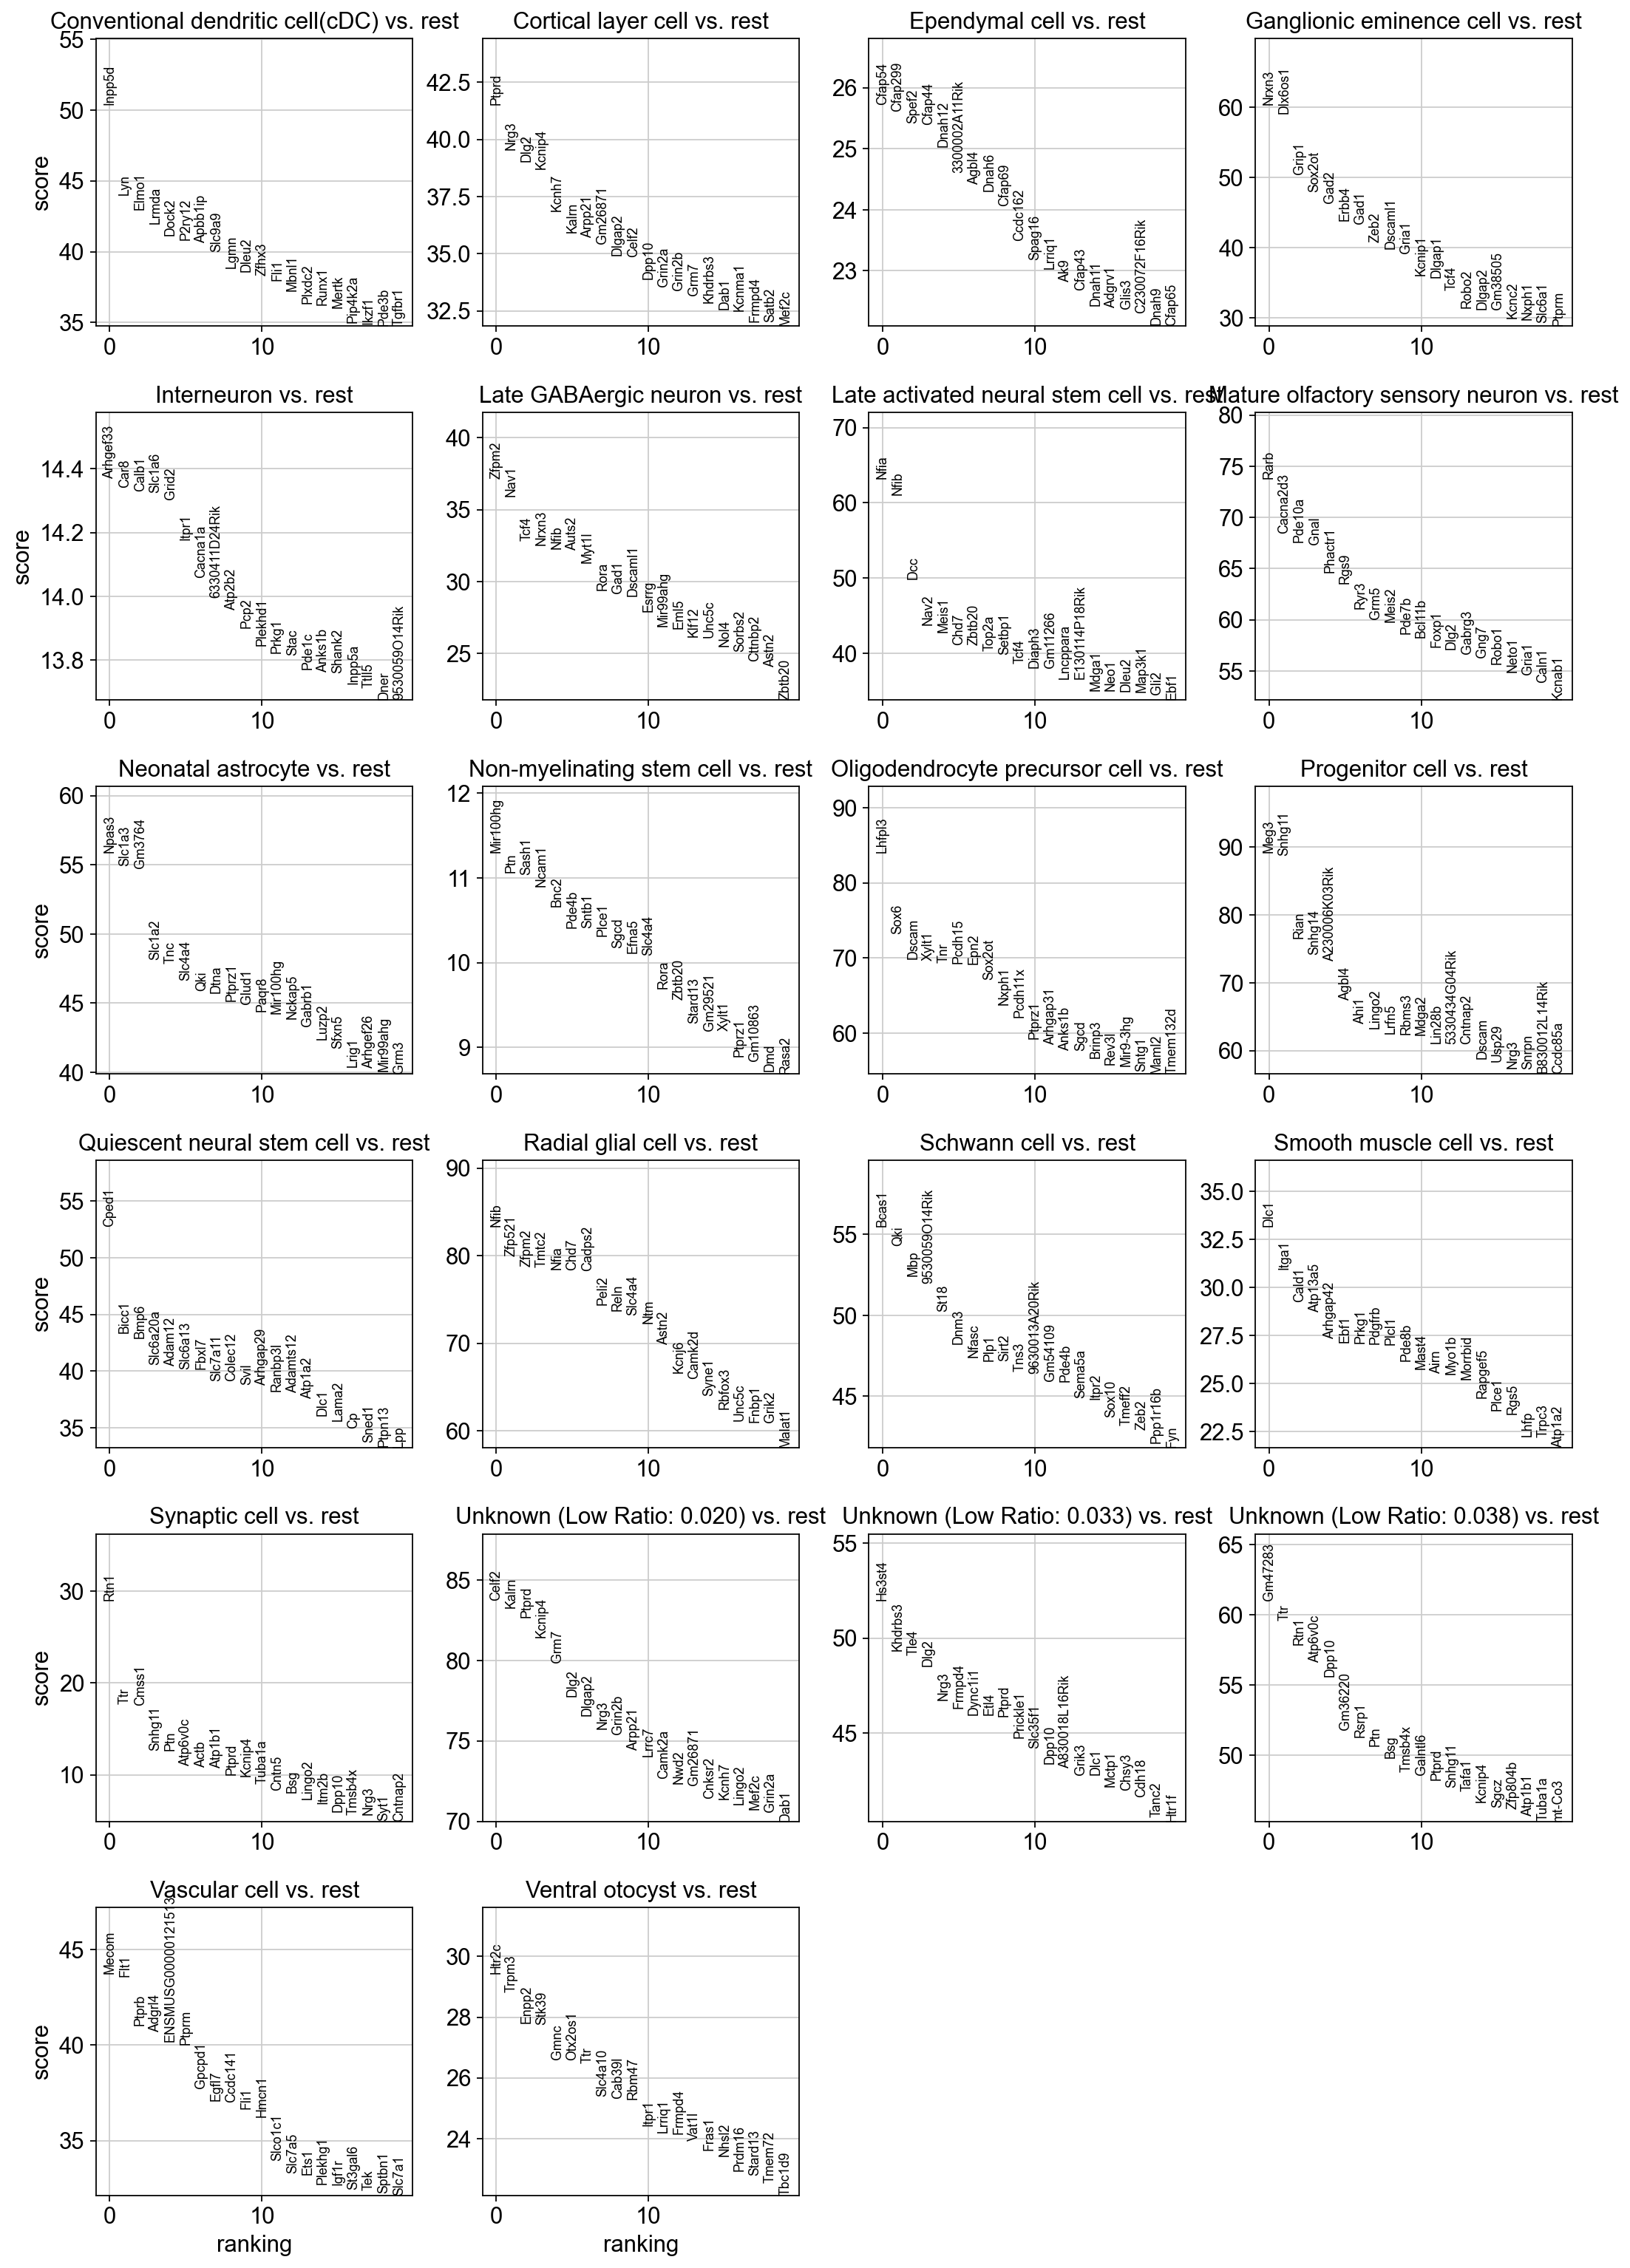


2. Plotting Dot Plot (Top 5 genes per group)...


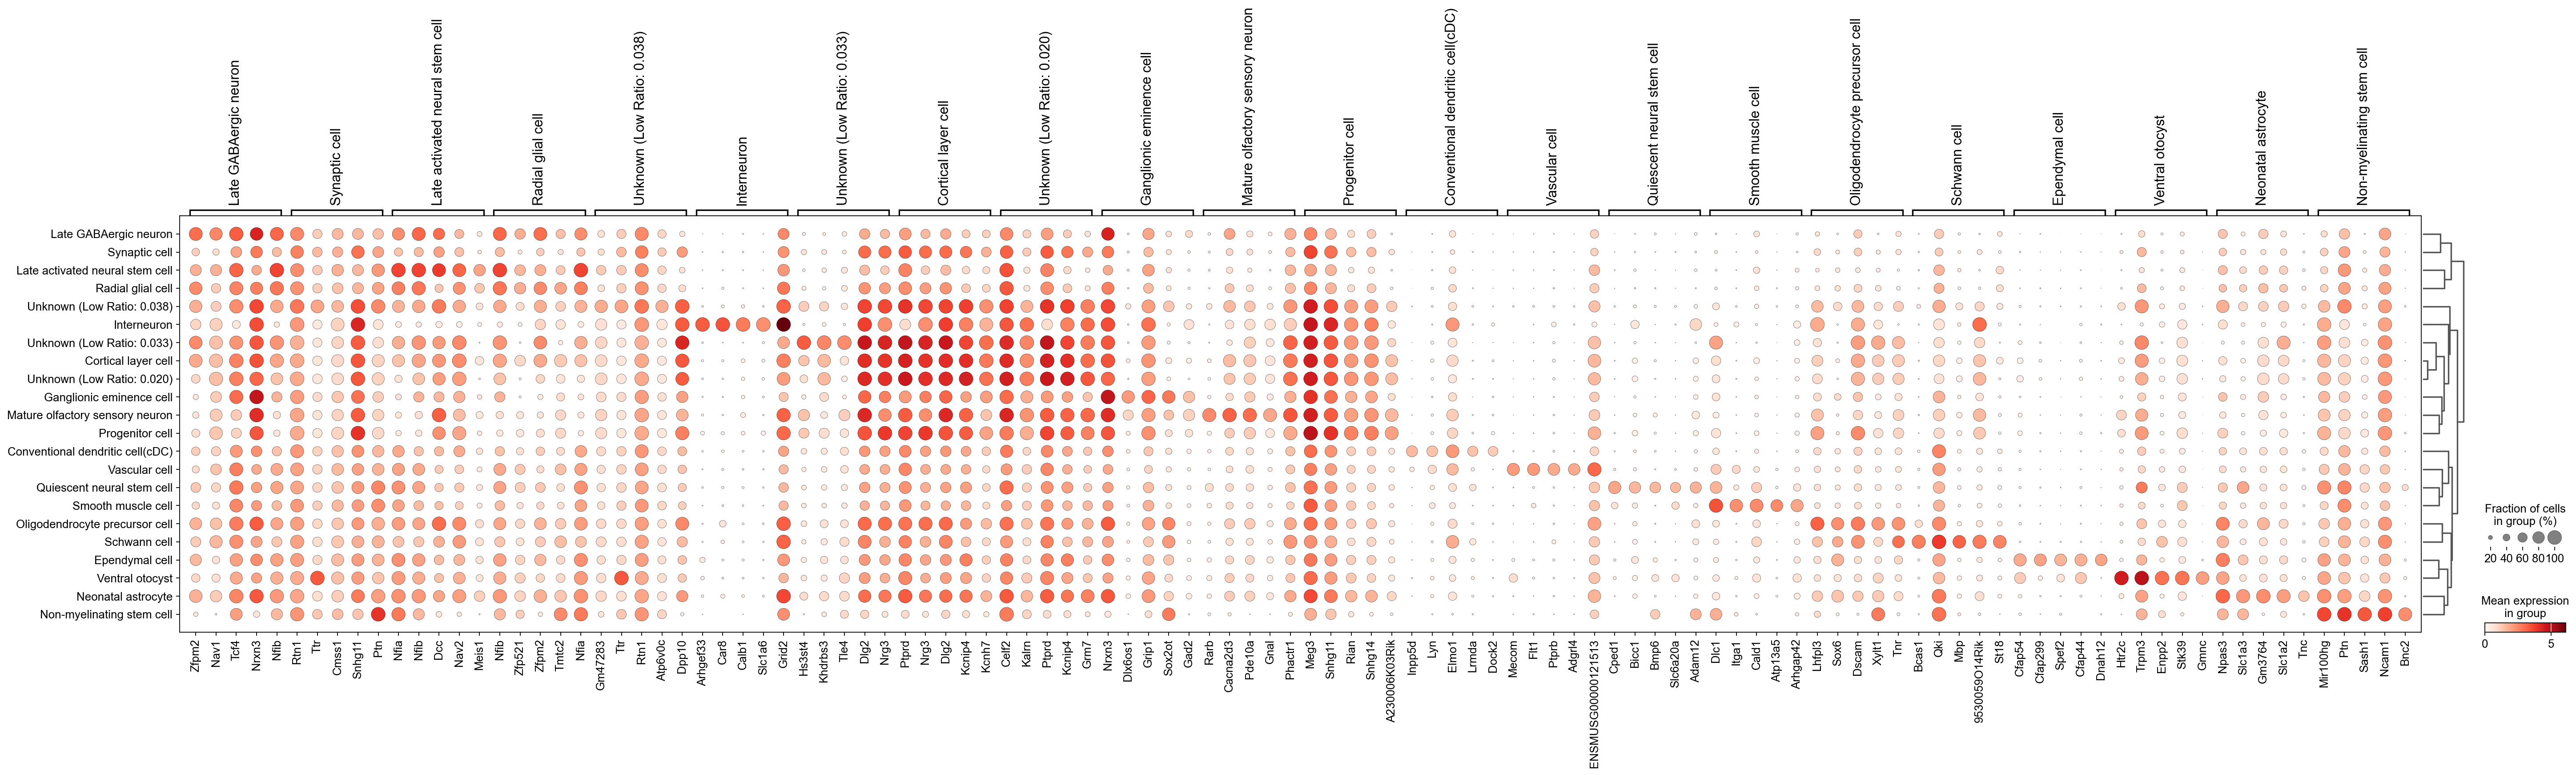


Displaying Top 10 marker genes per group from 'cell_type_auto_ratio':
  Conventional dendritic cell(cDC) Cortical layer cell Ependymal cell  \
0                           Inpp5d               Ptprd         Cfap54   
1                              Lyn                Nrg3        Cfap299   
2                            Elmo1                Dlg2          Spef2   
3                            Lrmda              Kcnip4         Cfap44   
4                            Dock2               Kcnh7         Dnah12   
5                           P2ry12               Kalrn  3300002A11Rik   
6                          Apbb1ip              Arpp21          Agbl4   
7                           Slc9a9             Gm26871          Dnah6   
8                             Lgmn              Dlgap2         Cfap69   
9                            Dleu2               Celf2        Ccdc162   

  Ganglionic eminence cell    Interneuron Late GABAergic neuron  \
0                    Nrxn3       Arhgef33                 

In [27]:
# Cell 16b: Finding Marker Genes for Automated Cell Types (Ratio-Based) - Corrected and Complete

# Ensure necessary libraries are imported (redundant if run sequentially, safe if run independently)
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

print("\n--- Cell 15b: Finding Marker Genes for AUTOMATED Cell Types (Ratio-Based) ---")

# --- Prerequisites Check ---
# These variables are assumed to be defined in previous cells.
# If running this cell standalone, you might need to define them explicitly.
# Example placeholders (replace with actual values from your notebook):
# output_prefix = "WT_sample_analysis" # Or whatever prefix you are using
# output_dir = "results/WT_analysis" # Or your defined output directory
# adata = sc.read_h5ad("path/to/your/processed_adata.h5ad") # Load adata if needed

if 'adata' not in locals():
    print("Error: 'adata' object not found. Please ensure previous cells have been run or load the AnnData object.")
    # exit() # Or raise an error if preferred
elif 'output_prefix' not in locals():
    print("Warning: 'output_prefix' not defined. Using a default value for filenames.")
    output_prefix = "scanpy_analysis"
elif 'output_dir' not in locals():
     print("Warning: 'output_dir' not defined. Saving files to current directory './figures/'.")
     output_dir = "." # Default to current directory
     sc.settings.figdir = "./figures/" # Scanpy default figdir if not set
     if not os.path.exists(sc.settings.figdir):
         os.makedirs(sc.settings.figdir)
# ---------------------------

# --- Configuration ---
# Use the specific annotation column generated by the automated ratio-based method in Cell 15
annotation_column_for_markers = 'cell_type_auto_ratio'
# --- ************ ---

# --- Validation ---
if annotation_column_for_markers not in adata.obs.columns:
    print(f"\nError: The specified annotation column '{annotation_column_for_markers}'")
    print(f"       (expected from Cell 15 - Automated Annotation) does not exist in adata.obs.")
    print(f"       Make sure Cell 15 ran successfully and created this column.")
    print(f"Available columns in adata.obs: {list(adata.obs.columns)}")
    print("\nSkipping marker gene finding for automated types in this cell.")
else:
    print(f"\nProceeding with marker gene finding using annotation column: '{annotation_column_for_markers}'")

    # Define the key where results will be stored in adata.uns
    marker_results_key_annotated = f"wilcoxon_{annotation_column_for_markers}"
    print(f"Results will be stored in adata.uns['{marker_results_key_annotated}']")

    # --- Data Preparation ---
    # Ensure the grouping column is categorical (handles potential DeprecationWarning)
    if not pd.api.types.is_categorical_dtype(adata.obs[annotation_column_for_markers]):
        print(f"Converting column '{annotation_column_for_markers}' to categorical type for analysis.")
        adata.obs[annotation_column_for_markers] = adata.obs[annotation_column_for_markers].astype('category')
    else:
        print(f"Column '{annotation_column_for_markers}' is already categorical.")

    # Report group sizes before analysis
    print("\nCell counts per group:")
    print(adata.obs[annotation_column_for_markers].value_counts())

    # --- Optional Filtering of 'Unknown' Groups ---
    run_on_subset = False # <<< Set to True if you want to EXCLUDE groups containing 'Unknown' >>>
    target_adata = adata  # Default to using the full AnnData object
    groups_to_run_on = list(adata.obs[annotation_column_for_markers].cat.categories)

    if run_on_subset:
        print("\nFiltering Activated: Checking for groups containing 'Unknown' to exclude...")
        initial_groups = list(adata.obs[annotation_column_for_markers].cat.categories)
        # Ensure comparison is case-insensitive and robust
        groups_to_keep = [g for g in initial_groups if 'unknown' not in str(g).lower()]

        if len(groups_to_keep) < len(initial_groups):
            groups_excluded = [g for g in initial_groups if g not in groups_to_keep]
            print(f"Excluding groups: {groups_excluded}")
            print(f"Analysis will run ONLY on groups: {groups_to_keep}")

            # Create a view/copy containing only the cells from the groups to keep
            adata_subset = adata[adata.obs[annotation_column_for_markers].isin(groups_to_keep), :].copy()
            target_adata = adata_subset # Perform analysis on this subset
            groups_to_run_on = groups_to_keep # Update the list of groups being analyzed
            print(f"Analysis will run on a subset of {target_adata.n_obs} cells.")
        else:
            print("No groups containing 'Unknown' found, or all groups are being kept.")
            print(f"Analysis will run on the full {target_adata.n_obs} cells (all groups).")
            # target_adata remains the original adata
    else:
        print("\nFiltering Deactivated: Analysis will run on all groups found.")
        print(f"Analysis will run on the full {target_adata.n_obs} cells.")
        # target_adata remains the original adata
    # --- End Optional Filtering ---

    # --- Run Differential Expression Analysis ---
    print(f"\nFinding marker genes for each group in '{annotation_column_for_markers}' (Wilcoxon rank-sum test)...")
    print(f"Comparison method: one-vs-rest")
    print(f"Using data from adata.raw if available, otherwise adata.X")

    try:
        # Perform the analysis on target_adata (full or subset)
        sc.tl.rank_genes_groups(target_adata,
                                groupby=annotation_column_for_markers,
                                groups=groups_to_run_on, # Explicitly state which groups to compare
                                method='wilcoxon', # Non-parametric test
                                use_raw=True,      # Use log1p normalized counts from raw attribute if possible
                                key_added=marker_results_key_annotated, # Store results with specific key
                                corr_method='benjamini-hochberg') # Method for p-value correction

        print("Marker gene calculation complete.")

        # --- Copy Results Back (if subset was used) ---
        # Check object identity, not equality (`is not` is safer here than `!=`)
        if target_adata is not adata:
            print(f"Copying marker results from subset back to the main AnnData object (adata.uns['{marker_results_key_annotated}']).")
            if marker_results_key_annotated in target_adata.uns:
                 adata.uns[marker_results_key_annotated] = target_adata.uns[marker_results_key_annotated].copy()
                 print("Results copied successfully.")
            else:
                 print(f"Warning: Expected results key '{marker_results_key_annotated}' not found in the subset's .uns slot. Cannot copy back.")
        # ---------------------------------------------

        # --- Visualize Results ---
        print("\nGenerating visualization plots for marker genes...")

        # Check if results exist in the *main* adata before plotting
        if marker_results_key_annotated in adata.uns:
            print(f"1. Plotting Heatmap (Top 20 genes per group)...")
            try:
                # Plot using the main adata, ensuring results are present there
                sc.pl.rank_genes_groups(adata,
                                       n_genes=20,          # Show top 20 genes per group
                                       sharey=False,        # Don't share y-axis (genes) across panels
                                       key=marker_results_key_annotated, # Use the correct results key
                                       fontsize=8,          # Adjust font size if needed
                                       # Save the plot to a file in the designated figures directory
                                       save=f"_{output_prefix}_markers_{annotation_column_for_markers}_heatmap.png")
                plt.show() # Ensure plot displays in notebook output if backend requires it
            except IndexError as ie:
                 print(f"  Error generating heatmap: {ie}")
                 print("  This can happen if a group has very few cells or genes with non-zero counts.")
            except ValueError as ve:
                 print(f"  Error generating heatmap: {ve}")
                 print("  This might indicate issues with group sizes or data structure.")
            except Exception as e:
                 print(f"  An unexpected error occurred during heatmap plotting: {e}")

            # Optional: Add other plot types here if desired
            print(f"\n2. Plotting Dot Plot (Top 5 genes per group)...")
            try:
                 sc.pl.rank_genes_groups_dotplot(adata,
                                                  n_genes=5,
                                                  key=marker_results_key_annotated,
                                                  groupby=annotation_column_for_markers,
                                                  save=f"_{output_prefix}_markers_{annotation_column_for_markers}_dotplot.png")
                 plt.show()
            except Exception as e:
                 print(f"  Could not generate dotplot: {e}")

            # Optional: Violin plot
            # print(f"\n3. Plotting Violin Plot (Top 5 genes per group)...")
            # try:
            #     sc.pl.rank_genes_groups_violin(adata,
            #                                     n_genes=5,
            #                                     key=marker_results_key_annotated,
            #                                     save=f"_{output_prefix}_markers_{annotation_column_for_markers}_violin.png")
            #     plt.show()
            # except Exception as e:
            #     print(f"  Could not generate violin plot: {e}")

        else:
            print(f"Error: Marker gene results key '{marker_results_key_annotated}' not found in main adata.uns. Cannot generate plots.")

        # --- Display Top Markers as Table ---
        print(f"\nDisplaying Top 10 marker genes per group from '{annotation_column_for_markers}':")
        if marker_results_key_annotated in adata.uns:
          try:
              # Extract the 'names' field which contains the ranked gene names for each group
              marker_names_df = pd.DataFrame(adata.uns[marker_results_key_annotated]['names'])
              print(marker_names_df.head(10))
          except KeyError:
               print(f"  Error: The 'names' field is missing within the results key '{marker_results_key_annotated}'.")
          except Exception as e:
              print(f"  Could not display marker table. Error: {e}")
        else:
          print(f"  Marker gene results key '{marker_results_key_annotated}' not found. Cannot display table.")

        # --- Optional: Save Full Marker List ---
        save_full_list = True # <<< Set to False if you don't want to save the full CSV list >>>
        if save_full_list:
            print(f"\nSaving full ranked list of marker genes for '{annotation_column_for_markers}'...")
            if marker_results_key_annotated in adata.uns:
              try:
                  # Use scanpy helper function to get a tidy DataFrame of all ranked genes
                  all_markers_df = sc.get.rank_genes_groups_df(adata, group=None, key=marker_results_key_annotated) # Group=None gets all groups

                  # Define the output path
                  # Ensure output_dir exists
                  if not os.path.exists(output_dir):
                      os.makedirs(output_dir)
                  all_markers_path = os.path.join(output_dir, f"{output_prefix}_all_markers_{marker_results_key_annotated}.csv")

                  # Save to CSV
                  all_markers_df.to_csv(all_markers_path, index=False)
                  print(f"  Full marker gene list saved successfully to: {all_markers_path}")
              except ValueError as ve_save:
                   print(f"  Could not retrieve or save full marker list: {ve_save}")
                   print(f"  Check if the results structure in adata.uns['{marker_results_key_annotated}'] is as expected.")
              except Exception as e_save:
                  print(f"  Could not save full marker list. An unexpected error occurred: {e_save}")
            else:
              print(f"  Marker gene results key '{marker_results_key_annotated}' not found. Cannot save full list.")
        else:
            print("\nSkipping saving of the full marker list as requested.")
        # --- End Optional Save ---

    # --- Error Handling for rank_genes_groups itself ---
    except ValueError as ve_rank:
        print(f"\nError during sc.tl.rank_genes_groups execution: {ve_rank}")
        print("This commonly occurs if:")
        print("  - A group selected for comparison has too few cells (Scanpy often requires >= 3).")
        print("  - All genes have zero variance within a group or across groups.")
        print("  - The `groupby` column contains unexpected values or NaNs.")
        print(f"  Review the cell counts per group listed above.")
        print("Skipping plotting and saving steps for this cell.")
    except MemoryError as me_rank:
        print(f"\nMemoryError during sc.tl.rank_genes_groups execution.")
        print("The dataset might be too large for the available RAM.")
        print("Consider downsampling, filtering, or using a machine with more memory.")
        print("Skipping plotting and saving steps for this cell.")
    except Exception as e_rank:
        print(f"\nAn unexpected error occurred during sc.tl.rank_genes_groups: {type(e_rank).__name__} - {e_rank}")
        print("Skipping plotting and saving steps for this cell.")

print("\n--- Cell 15b Finished ---")


In [ ]:
# Cell 17: Export Cell Barcodes and Annotations to CSV
import os # For joining paths

print("\n--- Step l: Exporting Cell Annotations to CSV ---")

# --- Configuration ---
# Define which annotation columns you want to include in the output CSV.
# The script will check if these columns exist in adata.obs before adding them.
# Common choices:
# 'leiden': Cluster ID (usually exists after Cell 11)
# 'cell_type_manual': Your manual annotation from Cell 14
# 'cell_type_auto_ratio': Annotation from ratio-based Cell 15
# 'cell_type_auto': Annotation from overlap-based Cell 15 (if you ran that version)
annotation_cols_to_check = [
    'leiden',
    'cell_type_manual',
    'cell_type_auto_ratio',
    # Add 'cell_type_auto' here if you ran the overlap version and want it too
]

# Define clear names for the columns in the output CSV file
output_column_names = {
    'index': 'Barcode', # Special handling for the index (barcode)
    'leiden': 'ClusterID',
    'cell_type_manual': 'ManualAnnotation',
    'cell_type_auto_ratio': 'AutoAnnotationRatio',
    'cell_type_auto': 'AutoAnnotationOverlap' # Make sure key matches above list if used
}

# Define the output filename
output_csv_filename = f"{output_prefix}_cell_annotations.csv"
output_csv_path = os.path.join(output_dir, output_csv_filename)
# --- End Configuration ---

try:
    # Identify which of the desired annotation columns actually exist in adata.obs
    columns_to_export = []
    final_rename_map = {'index': output_column_names['index']} # Start with barcode mapping

    for col in annotation_cols_to_check:
        if col in adata.obs.columns:
            columns_to_export.append(col)
            if col in output_column_names:
                 final_rename_map[col] = output_column_names[col] # Add renaming entry if defined
            # else: # Optional: handle columns not in rename map, use original name
            #    final_rename_map[col] = col
        else:
            print(f"Info: Column '{col}' not found in adata.obs, will not be exported.")

    # Check if at least one column (besides barcode) was found
    if not columns_to_export:
        print("Error: No valid annotation columns found to export (checked: {}). Cannot create CSV.".format(annotation_cols_to_check))
    else:
        # Create a DataFrame with the cell barcodes (index) and the selected columns
        # Use .reset_index() to turn the barcode index into a column
        export_df = adata.obs[columns_to_export].reset_index()

        # Select only the columns we intend to export (index + found annotations)
        # Ensure 'index' (barcode) is included
        final_columns_order = ['index'] + columns_to_export
        export_df = export_df[final_columns_order]

        # Rename the columns for the final CSV file
        export_df = export_df.rename(columns=final_rename_map)

        # Save the DataFrame to a CSV file
        export_df.to_csv(output_csv_path, index=False) # index=False prevents writing pandas index

        print(f"\nSuccessfully exported cell annotations to: {output_csv_path}")
        print("CSV Columns:", list(export_df.columns))
        print("First 5 rows of exported data:")
        print(export_df.head())

except Exception as e:
    print(f"An error occurred during CSV export: {e}")



In [ ]:
# Cell 18: Trajectory Inference using PAGA and Diffusion Pseudotime (DPT)
print("\n--- Starting Trajectory Analysis ---")

# 1. Run PAGA to understand cluster connectivity
print("Running PAGA...")
sc.tl.paga(adata, groups='leiden')

# Plot PAGA graph (nodes = clusters, edges = connection confidence)
sc.pl.paga(adata, color=['leiden'], title='PAGA graph (Cluster Connectivities)', frameon=False,
           threshold=0.1, # Adjust threshold to show stronger connections
           show=False, save=f'_{output_prefix}_paga_graph.png')

# Plot PAGA graph overlaid on UMAP
sc.pl.umap(adata, color='leiden', legend_loc='on data', title='UMAP with PAGA connections',
           add_outline=False, # Add outlines around clusters
           legend_fontsize=10, frameon=False,
           show=False, save=f'_{output_prefix}_umap_paga_connections.png')

# Option: Recompute UMAP initialized with PAGA for potentially clearer trajectory layout
# print("Recomputing UMAP initialized by PAGA...")
# sc.tl.umap(adata, init_pos='paga')
# sc.pl.umap(adata, color='leiden', legend_loc='on data', title='UMAP initialized by PAGA', frameon=False,
#            show=False, save=f'_{output_prefix}_umap_paga_init.png')


# 2. Identify the Root Cluster/Cell
# !!! CRITICAL STEP: YOU MUST CHOOSE THE ROOT !!!
# Based on your biological knowledge and inspection of the UMAP/PAGA plots,
# identify the cluster representing the start of the process (e.g., stem cells, earliest time point).
# Replace 'X' with the actual Leiden cluster ID.
# Check the cluster IDs by looking at the '_umap_leiden.png' plot or `adata.obs['leiden'].cat.categories`
root_cluster_id = '0' # <--- *** CHANGE THIS TO YOUR ACTUAL ROOT CLUSTER ID (e.g., '3', '5') ***

# Verify the chosen root cluster exists
available_clusters = list(adata.obs['leiden'].cat.categories)
if root_cluster_id not in available_clusters:
    raise ValueError(f"Root cluster '{root_cluster_id}' not found in adata.obs['leiden']. "
                     f"Available clusters are: {available_clusters}")

# Find the index of the first cell belonging to the root cluster
# This cell will be used as the root for DPT calculation.
root_indices = np.where(adata.obs['leiden'] == root_cluster_id)[0]
if len(root_indices) == 0:
     # This check should technically be redundant due to the check above, but good practice
     raise ValueError(f"No cells found for the specified root cluster '{root_cluster_id}'.")

adata.uns['iroot'] = root_indices[0] # Assign root cell index for DPT
print(f"Selected root cluster: Leiden '{root_cluster_id}'. Using cell index {adata.uns['iroot']} as the DPT root.")


# 3. Compute Diffusion Pseudotime (DPT)
# DPT calculates pseudotime based on diffusion distances from the root cell.
print("Calculating Diffusion Pseudotime (DPT)...")
# You might need to adjust n_dcs (number of diffusion components)
sc.tl.diffmap(adata, n_comps=15) # Calculate diffusion map first
sc.tl.dpt(adata, n_dcs=10)       # Calculate DPT using diffmap results

# 4. Visualize Pseudotime on UMAP
print("Visualizing pseudotime...")
# Pseudotime is stored in adata.obs['dpt_pseudotime']
sc.pl.umap(adata, color=['dpt_pseudotime'], cmap='viridis', # 'viridis_r' reverses colormap if needed
           title='Diffusion Pseudotime (DPT)', frameon=False,
           show=False, save=f'_{output_prefix}_umap_dpt_pseudotime.png')

# Visualize DPT alongside clusters for context
sc.pl.umap(adata, color=['leiden', 'dpt_pseudotime'], cmap='viridis', wspace=0.3, frameon=False,
           title=['Leiden Clusters', 'DPT'],
           show=False, save=f'_{output_prefix}_umap_leiden_vs_dpt.png')

# (Optional) Plot expression of key genes along pseudotime
# Use genes expected to change along the inferred trajectory.
# These genes must be in adata.var_names (i.e., were selected as HVGs) or use use_raw=True.
# trajectory_markers = ['GeneA', 'GeneB', 'GeneC'] # <--- CHANGE THESE GENE NAMES
# markers_to_plot = [gene for gene in trajectory_markers if gene in adata.raw.var_names] # Check in raw data
#
# if markers_to_plot:
#     print(f"Plotting expression of {markers_to_plot} along pseudotime...")
#     # Plotting expression from raw data ensures you see all marker genes
#     sc.pl.umap(adata, color=['dpt_pseudotime'] + markers_to_plot, use_raw=True, cmap='viridis', frameon=False,
#                layer=None, # Use log1p normalized counts from raw
#                show=False, save=f'_{output_prefix}_umap_dpt_and_genes.png')
# else:
#     print(f"None of the specified trajectory marker genes ({trajectory_markers}) found in adata.raw.var_names.")

print("--- Trajectory Analysis Complete ---")

# 4. Visualize Trajectory on UMAP
print("Visualizing trajectory structure and pseudotime...")

# --- PLOT 1: UMAP colored by clusters WITH PAGA trajectory overlay ---
# This plot shows the connections (trajectory tracks) between cluster centroids
# based on the PAGA graph, drawn on top of the UMAP colored by clusters.
sc.pl.paga_compare(
    adata,
    basis='umap',         # Specify the embedding to use ('X_umap' in adata.obsm)
    color='leiden',       # Color underlying UMAP points by cluster
    edges=True,           # Draw PAGA edges connecting cluster centroids/abstractions
    threshold=0.05,       # PAGA connection confidence threshold (adjust as needed)
    edge_width_scale=0.8, # Adjust thickness of trajectory lines
    node_size_scale=0,    # Hide the abstract PAGA nodes if desired
    frameon=False,
    title='UMAP Clusters with PAGA Trajectory Tracks',
    show=False,
    save=f'_{output_prefix}_paga_compare_umap_overlay.png'
)

# --- PLOT 2: Standard UMAP colored by DPT pseudotime ---
# This plot shows the progression along the trajectory via color gradient.
sc.pl.umap(
    adata,
    color=['dpt_pseudotime'],
    cmap='viridis',
    title='Diffusion Pseudotime (DPT)',
    frameon=False,
    show=False,
    save=f'_{output_prefix}_umap_dpt_pseudotime_only.png'
)

# --- (Optional) PLOT 3: UMAP colored by clusters (without trajectory overlay) ---
# Useful for comparison or if the overlay is too busy
sc.pl.umap(adata, color=['leiden'], legend_loc='on data', title='Leiden Clusters (No Overlay)',
            frameon=False, show=False, save=f'_{output_prefix}_umap_leiden_only.png')

print("--- Trajectory Visualization Complete ---")


In [ ]:
# Cell 19: Cell Type-Based Trajectory Inference (PAGA & DPT) & Gene Dynamics

import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

print("\n--- Cell 19: Cell Type-Based Trajectory Analysis (PAGA, DPT) & Gene Dynamics ---")

# --- Prerequisites Check ---
# Ensure essential variables from previous cells are available
if 'adata' not in locals():
    raise NameError("Variable 'adata' is not defined. Please run previous cells (1-17) first.")
if 'output_dir' not in locals() or 'output_prefix' not in locals():
    raise NameError("Variables 'output_dir' and/or 'output_prefix' are not defined. Please run Cell 1 first.")
if 'cell_type_auto_ratio' not in adata.obs.columns:
     raise KeyError("Column 'cell_type_auto_ratio' (expected from Cell 16) not found in adata.obs. Please ensure Cell 16 ran successfully.")

# Ensure Scanpy figure directory is set (usually done in Cell 1)
sc.settings.figdir = output_dir
# --- Configuration ---
# Specify the column containing the cell type annotations to use for grouping
# This should match the output column name from Cell 16 (the ratio-based one)
annotation_column = 'cell_type_auto_ratio'

# !!! Root Cell Type Definition !!!
# Based on analysis of Cell 16 results and biological context (adult mouse striatum)
root_cell_type = 'Oligodendrocyte precursor cell' # <--- Set based on your identified OPC cluster name

# !!! Gene Dynamics Definition !!!
# Using a combined list: some top OPC markers from user list + canonical dynamic markers
# This provides a better view of changes across the full trajectory (OPC -> OL)
genes_to_plot_dynamics = [
    'Ptprz1', # Strong OPC marker from user's list
    'Vcan',   # Strong OPC marker from user's list
    'Pdgfra', # Canonical OPC marker (verify symbol in your data)
    'Gpr17',  # Intermediate/Immature OL marker (verify symbol)
    'Mbp',    # Mature OL marker (verify symbol)
    'Plp1'    # Mature OL marker (verify symbol)
]
# --- End Configuration ---


# --- Validation ---
# Double-check annotation column exists
if annotation_column not in adata.obs.columns:
    raise KeyError(f"Annotation column '{annotation_column}' still not found in adata.obs.")

# Ensure the chosen column is categorical for PAGA/plotting
if not pd.api.types.is_categorical_dtype(adata.obs[annotation_column]):
     print(f"Converting column '{annotation_column}' to categorical type...")
     adata.obs[annotation_column] = adata.obs[annotation_column].astype('category')

# Verify the chosen root cell type exists within the annotation column
available_cell_types = list(adata.obs[annotation_column].cat.categories)
if root_cell_type not in available_cell_types:
    raise ValueError(f"Chosen root cell type '{root_cell_type}' was not found in the '{annotation_column}' column. "
                     f"Available types are: {available_cell_types}. Please check the 'root_cell_type' setting.")

print(f"Using annotation column: '{annotation_column}'")
print(f"Chosen root cell type for DPT: '{root_cell_type}'")
# Verify the selected genes actually exist in the data before proceeding
genes_exist_check = []
source_adata_check = adata.raw if hasattr(adata, 'raw') else adata
if source_adata_check is not None:
    genes_exist_check = [g for g in genes_to_plot_dynamics if g in source_adata_check.var_names]
    missing_genes = [g for g in genes_to_plot_dynamics if g not in source_adata_check.var_names]
    if missing_genes:
        print(f"Warning: The following genes specified for dynamics plot were NOT found in adata.raw/adata: {missing_genes}")
        print("They will be skipped during plotting.")
    if not genes_exist_check:
         print("Warning: NONE of the specified genes for dynamics plot were found in the data!")
    genes_to_plot_dynamics = genes_exist_check # Update list to only include genes that exist
else:
    print("Warning: Cannot check for gene existence as adata.raw/adata is not available.")

print(f"Genes selected for dynamics plot (and found in data): {genes_to_plot_dynamics}")


# --- 1. Run PAGA using Cell Type Annotations ---
print("\nRunning PAGA based on cell types...")
try:
    sc.tl.paga(adata, groups=annotation_column)
    print("PAGA calculation complete.")
except Exception as e:
    print(f"Error during PAGA calculation: {e}")
    raise


# --- 2. Visualize PAGA Results (Cell Type Based) ---
print("Plotting PAGA results...")

paga_plot_title = f'PAGA Graph ({annotation_column})'
paga_save_path = f'_{output_prefix}_paga_graph_{annotation_column}.png'
try:
    sc.pl.paga(adata,
               color=[annotation_column],
               title=paga_plot_title,
               node_size_scale=1.5,
               fontsize=8,
               frameon=False,
               threshold=0.05,
               show=False,
               save=paga_save_path)
    plt.show()
    print(f"Saved PAGA graph plot to {os.path.join(output_dir, 'figures', paga_save_path.strip('_'))}")
except Exception as e:
    print(f"Error plotting PAGA graph: {e}")


paga_compare_title = f'UMAP with PAGA Connections ({annotation_column})'
paga_compare_save_path = f'_{output_prefix}_paga_compare_umap_{annotation_column}.png'
try:
    sc.pl.paga_compare(
        adata,
        basis='umap',
        color=annotation_column,
        edges=True,
        threshold=0.05,
        edge_width_scale=0.8,
        node_size_scale=1.0,
        legend_loc='on data',
        legend_fontsize=8,
        frameon=False,
        title=paga_compare_title,
        show=False,
        save=paga_compare_save_path)
    plt.show()
    print(f"Saved PAGA compare plot to {os.path.join(output_dir, 'figures', paga_compare_save_path.strip('_'))}")
except Exception as e:
    print(f"Error plotting PAGA compare on UMAP: {e}")


# --- 3. Identify Root Cell for DPT ---
print(f"\nIdentifying root cell index within cell type '{root_cell_type}'...")
root_indices = np.where(adata.obs[annotation_column] == root_cell_type)[0]
if len(root_indices) == 0:
     raise RuntimeError(f"Internal Error: No cells found for the root cell type '{root_cell_type}', though the type exists. Check data integrity.")
adata.uns['iroot'] = root_indices[0]
print(f"Using cell index {adata.uns['iroot']} (the first cell found in type '{root_cell_type}') as the DPT root.")


# --- 4. Compute Diffusion Map and DPT ---
print("Calculating Diffusion Map...")
try:
    sc.tl.diffmap(adata, n_comps=15)
    print("Diffusion Map calculation complete.")
except Exception as e:
    print(f"Error calculating Diffusion Map: {e}")
    raise

print("Calculating Diffusion Pseudotime (DPT)...")
try:
    sc.tl.dpt(adata, n_dcs=10)
    print("DPT calculation complete. Pseudotime stored in adata.obs['dpt_pseudotime'].")
except Exception as e:
    print(f"Error calculating DPT: {e}")
    raise


# --- 5. Visualize DPT Results ---
print("Visualizing pseudotime based on cell type root...")

dpt_plot_title = f'Diffusion Pseudotime (Root: {root_cell_type})'
dpt_save_path = f'_{output_prefix}_umap_dpt_{annotation_column}_root.png'
try:
    sc.pl.umap(adata,
               color=['dpt_pseudotime'],
               cmap='viridis',
               title=dpt_plot_title,
               frameon=False,
               show=False,
               save=dpt_save_path)
    plt.show()
    print(f"Saved DPT UMAP plot to {os.path.join(output_dir, 'figures', dpt_save_path.strip('_'))}")
except Exception as e:
    print(f"Error plotting DPT on UMAP: {e}")

dpt_compare_save_path = f'_{output_prefix}_umap_type_vs_dpt_{annotation_column}_root.png'
try:
    sc.pl.umap(adata,
               color=[annotation_column, 'dpt_pseudotime'],
               cmap='viridis',
               wspace=0.3,
               frameon=False,
               title=[f'{annotation_column}', f'DPT (Root: {root_cell_type})'],
               legend_loc='on data',
               show=False,
               save=dpt_compare_save_path)
    plt.show()
    print(f"Saved side-by-side Cell Type vs DPT UMAP plot to {os.path.join(output_dir, 'figures', dpt_compare_save_path.strip('_'))}")
except Exception as e:
    print(f"Error plotting side-by-side Cell Type vs DPT UMAP: {e}")


# --- 6. Visualize Gene Expression Dynamics along Pseudotime ---
print("\nPlotting gene expression dynamics along pseudotime...")

# Check source data availability again before plotting loop
use_raw_data = hasattr(adata, 'raw') and adata.raw is not None
data_source_name = "adata.raw" if use_raw_data else "adata"

if not genes_to_plot_dynamics: # Check if the list is empty after validation
    print("No requested (and available) genes for dynamics plotting. Skipping dynamics plots.")
else:
    print(f"Plotting dynamics for found genes: {genes_to_plot_dynamics} (using data from {data_source_name})")

    for gene in genes_to_plot_dynamics: # Iterate only over genes confirmed to exist
        plot_title = f'{gene} Expression vs Pseudotime (Root: {root_cell_type})'
        dynamics_save_path = f'_{output_prefix}_gene_dynamics_{gene}_{annotation_column}_root.png'
        try:
            sc.pl.scatter(adata,
                          x='dpt_pseudotime',
                          y=gene,
                          color=annotation_column,
                          title=plot_title,
                          use_raw=use_raw_data, # Use raw if available
                          show=False,
                          save=dynamics_save_path)
            plt.show()
            print(f"Saved '{gene}' dynamics plot to {os.path.join(output_dir, 'figures', dynamics_save_path.strip('_'))}")
        except Exception as e:
            print(f"Error plotting dynamics for gene '{gene}': {e}")

# --- 7. (Optional) Save AnnData with Cell Type PAGA/DPT results ---
save_final_adata = True
if save_final_adata:
    final_adata_path_traj = os.path.join(output_dir, f"{output_prefix}_final_with_celltype_trajectory.h5ad")
    print(f"\nSaving final AnnData object with cell type trajectory results to: {final_adata_path_traj}")
    try:
        adata.write(final_adata_path_traj)
        print("Final AnnData object with trajectory saved successfully.")
    except Exception as e:
        print(f"Error saving final AnnData object: {e}")
else:
    print("\nSkipping final AnnData object save as requested.")


print("\n--- Cell 19 Finished: Cell Type Trajectory Analysis Complete ---")


In [ ]:
# Cell 20 (Revised): Heatmap with Explicit Top 20 Genes per Cell Type (Fixed Size)

import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
# import itertools # No longer needed for unique genes

print("\n--- Cell 20 (Revised): Heatmap with Explicit Top 20 Genes per Cell Type (Fixed Size) ---")

# --- Prerequisites Check ---
if 'adata' not in locals():
    raise NameError("Variable 'adata' is not defined. Please run previous cells first.")
if 'output_dir' not in locals() or 'output_prefix' not in locals():
    raise NameError("Variables 'output_dir' and/or 'output_prefix' are not defined. Please run Cell 1 first.")

annotation_column = 'cell_type_auto_ratio' # Make sure this matches Cell 16
marker_results_key = f"wilcoxon_{annotation_column}" # Make sure this matches Cell 16b

if annotation_column not in adata.obs.columns:
    raise KeyError(f"Annotation column '{annotation_column}' not found in adata.obs.")
if marker_results_key not in adata.uns:
    raise KeyError(f"Marker gene results key '{marker_results_key}' not found in adata.uns.")
if 'names' not in adata.uns[marker_results_key]:
    raise KeyError(f"Marker gene results key '{marker_results_key}' missing 'names' field.")

sc.settings.figdir = output_dir
# --- Configuration ---
n_top_genes = 20
color_map = 'RdBu_r' # Diverging colormap, good for Z-scores
color_min = -1.5      # Adjust Z-score min for color scale if needed
color_max = 2.5       # Adjust Z-score max for color scale if needed
export_example_zscores = True # Keep Z-score export for one example gene
# --- End Configuration ---

print(f"Generating heatmap using annotation: '{annotation_column}'")
print(f"Fetching top {n_top_genes} marker genes per group from key: '{marker_results_key}'")
print(f"Genes *will* be duplicated on the Y-axis if they are top markers for multiple cell types.")
print(f"Heatmap size will be fixed to match original version (10x9 inches).") # Added note

# --- Construct Gene List and Group Mapping (Allowing Duplicates) ---
genes_to_plot_ordered_with_duplicates = []
var_group_labels = []
var_group_positions = []
raw_marker_lists = {} # Store the original lists per group

try:
    marker_groups = list(adata.uns[marker_results_key]['names'].dtype.names)
    print(f"Found marker gene results for groups: {marker_groups}")
    obs_groups = list(adata.obs[annotation_column].cat.categories)
    if set(marker_groups) != set(obs_groups):
        print(f"Warning: Groups in marker results ({len(marker_groups)}) differ from groups in annotation ({len(obs_groups)}). Plotting based on marker result groups.")
        # Optional: Filter marker_groups to only include those present in obs_groups if desired
        # marker_groups = [g for g in marker_groups if g in obs_groups]
        # print(f"Using intersection of groups: {marker_groups}")

except Exception as e:
    print(f"Error accessing group names from marker results key '{marker_results_key}': {e}")
    raise

current_pos = 0
first_gene_first_group = None # Variable to store the target gene for export

for i, group in enumerate(marker_groups):
    try:
        # Retrieve top N genes for this group
        top_genes_for_group_raw = adata.uns[marker_results_key]['names'][group][:n_top_genes]
        # Decode bytes if necessary and convert to string list
        top_genes_for_group = [g.decode('utf-8') if isinstance(g, bytes) else str(g) for g in top_genes_for_group_raw]

        # Store the raw list for potential use later
        raw_marker_lists[group] = top_genes_for_group

        # Check if any genes were actually found for this group
        num_genes_in_group = len(top_genes_for_group)
        if num_genes_in_group == 0:
             print(f"Warning: No marker genes found for group '{group}' within top {n_top_genes}. Skipping this group for heatmap gene list.")
             continue # Skip to the next group if no genes

        # Store the first gene of the first valid group for Z-score export example
        if i == 0 and num_genes_in_group > 0:
            first_gene_first_group = top_genes_for_group[0]

        # Add these genes (potentially duplicates) to the final ordered list
        genes_to_plot_ordered_with_duplicates.extend(top_genes_for_group)

        # Define the position and label for this group's block of genes
        start_index = current_pos
        end_index = current_pos + num_genes_in_group - 1
        var_group_positions.append((start_index, end_index))
        var_group_labels.append(group) # Use the cell type name as the label

        # Update the starting position for the next block
        current_pos += num_genes_in_group

    except Exception as e: # Catch potential errors during retrieval for a specific group
        print(f"Warning: Could not retrieve or process markers for group '{group}'. Skipping. Error: {e}")
        continue

if not genes_to_plot_ordered_with_duplicates:
    raise ValueError("Failed to extract any valid marker genes. Cannot generate heatmap.")

print(f"Constructed final ordered list of {len(genes_to_plot_ordered_with_duplicates)} genes (including duplicates) across {len(var_group_labels)} groups.")
print(f"Each group block on the Y-axis corresponds to its top {n_top_genes} identified markers.")

# --- (Optional but Recommended) Verify Genes Exist ---
# Check if genes exist in adata.raw.var_names (more robust plotting)
genes_actually_in_data = []
if hasattr(adata, 'raw') and adata.raw is not None:
    print("Verifying gene names against adata.raw.var_names...")
    genes_in_raw = set(adata.raw.var_names)
    original_count = len(genes_to_plot_ordered_with_duplicates)
    genes_to_plot_verified = [g for g in genes_to_plot_ordered_with_duplicates if g in genes_in_raw]
    removed_count = original_count - len(genes_to_plot_verified)
    if removed_count > 0:
        print(f"Warning: Removed {removed_count} genes from the plot list because they were not found in adata.raw.var_names.")
        print("Proceeding with the original gene list; sc.pl.heatmap will likely skip missing genes.")
        final_genes_for_plot = genes_to_plot_ordered_with_duplicates # Use original list
    else:
        print("All requested marker genes were found in adata.raw.var_names.")
        final_genes_for_plot = genes_to_plot_ordered_with_duplicates # Use original list
else:
    print("Warning: adata.raw not found. Cannot verify gene names against it. Plotting based on marker list.")
    final_genes_for_plot = genes_to_plot_ordered_with_duplicates # Use original list

# --- Export Z-scores for the first gene (Unaffected by duplicate logic) ---
if export_example_zscores and first_gene_first_group:
    print(f"\nCalculating and exporting Z-scores for example gene: '{first_gene_first_group}'")
    try:
        # Find the expression vector (prefer raw)
        expr_vector = None
        source_msg = ""
        if hasattr(adata, 'raw') and first_gene_first_group in adata.raw.var_names:
            expr_vector = adata.raw[:, first_gene_first_group].X.toarray().flatten()
            source_msg = "from adata.raw"
        elif first_gene_first_group in adata.var_names:
            if isinstance(adata[:, first_gene_first_group].X, np.ndarray):
                expr_vector = adata[:, first_gene_first_group].X.flatten()
            else: # sparse
                expr_vector = adata[:, first_gene_first_group].X.toarray().flatten()
            source_msg = "from adata.X (adata.raw preferred)"
        else:
             raise ValueError(f"Gene '{first_gene_first_group}' not found in adata.raw or adata.")

        mean_expr = np.mean(expr_vector)
        std_dev_expr = np.std(expr_vector)
        print(f"  Using expression data {source_msg} for '{first_gene_first_group}'.")
        print(f"  Mean log1p expression: {mean_expr:.4f}, Std Dev: {std_dev_expr:.4f}")

        if std_dev_expr == 0:
            print("  Standard deviation is zero. Setting all Z-scores to 0.")
            z_scores_vector = np.zeros_like(expr_vector)
        else:
            z_scores_vector = (expr_vector - mean_expr) / std_dev_expr

        export_df = pd.DataFrame({
            'Barcode': adata.obs_names,
            'CellType': adata.obs[annotation_column].tolist(),
            f'{first_gene_first_group}_Log1pExpr': expr_vector,
            f'{first_gene_first_group}_ZScore': z_scores_vector
        })

        csv_filename = f"{output_prefix}_zscores_{first_gene_first_group}.csv"
        csv_output_path = os.path.join(output_dir, csv_filename)
        export_df.to_csv(csv_output_path, index=False)
        print(f"  Successfully exported expression and Z-scores to: {csv_output_path}")
        print(f"  Z-score range in exported file: Min={np.min(z_scores_vector):.4f}, Max={np.max(z_scores_vector):.4f}")

    except Exception as e_export:
        print(f"  Error exporting Z-scores for '{first_gene_first_group}': {type(e_export).__name__}: {e_export}")
elif export_example_zscores:
    print("\nSkipping Z-score export: Could not identify the first gene from the first valid group.")
# --- End of Z-score Export Section ---


# --- Generate and Plot Heatmap with Explicit Gene Blocks (Fixed Size) --- # MODIFIED section title
heatmap_save_path = f'_{output_prefix}_heatmap_top{n_top_genes}_markers_{annotation_column}_explicit_blocks_fixed_size.png' # MODIFIED save name

# Ensure the figures directory exists
figures_dir = os.path.join(output_dir, 'figures')
if not os.path.exists(figures_dir):
    os.makedirs(figures_dir)
    print(f"Created directory: {figures_dir}")

try:
    print(f"\nGenerating heatmap with explicit gene blocks per cell type (Fixed Size)...") # MODIFIED print statement
    print(f"  Color scale (Z-score): {color_min} to {color_max}")
    print(f"  Y-axis will have {len(final_genes_for_plot)} genes total.")
    print(f"  Figure size fixed at (10, 9) inches.") # ADDED print statement

    # *** REMOVED dynamic height/width calculation ***
    # est_height = max(8, len(final_genes_for_plot) * 0.15)
    # est_width = 10

    sc.pl.heatmap(
        adata,
        var_names=final_genes_for_plot, # Use the ordered list WITH duplicates
        groupby=annotation_column,
        use_raw=True,                # Use log1p normalized data from raw
        cmap=color_map,              # Color map
        dendrogram=False,            # No dendrogram for cell types
        standard_scale='var',        # Z-score scale per gene (row)
        vmin=color_min,              # Set minimum color limit
        vmax=color_max,              # Set maximum color limit
        show_gene_labels=False,      # Gene labels likely too crowded
        var_group_labels=var_group_labels, # Labels for gene blocks (cell types)
        var_group_positions=var_group_positions, # Positions for gene blocks
        var_group_rotation=90,       # Rotate gene group labels if needed
        figsize=(10, 9),             # *** FIXED figsize to match original ***
        show=False,                  # Don't show immediately
        save=heatmap_save_path       # Use Scanpy's save mechanism
    )
    # Add a more informative title manually
    plt.suptitle(f'Top {n_top_genes} Markers per {annotation_column} (Explicit Blocks, Fixed Size)\nRelative Expression (Z-score capped at {color_min}/{color_max})', y=1.01, fontsize=10) # MODIFIED suptitle
    plt.tight_layout(rect=[0, 0.02, 1, 0.99]) # Adjust layout
    plt.show() # Display the plot inline
    print(f"Saved heatmap plot to {os.path.join(figures_dir, heatmap_save_path.strip('_'))}")

except ValueError as ve:
    print(f"Error generating heatmap: {ve}")
    print("This might occur if gene names are incorrect or lists are mismatched.")
except KeyError as ke:
     print(f"Error generating heatmap: {ke}")
     print("This might indicate an issue accessing data within the AnnData object.")
except Exception as e:
    print(f"An unexpected error occurred during heatmap generation: {type(e).__name__}: {e}")


print("\n--- Cell 20 (Revised Fixed Size) Finished ---") # MODIFIED final print



--- Cell 20: Heatmap of Top Automated Marker Genes (Corrected + Fixed Color Scale + Z-Score Export + Gene Bar by Cell Type) ---
Generating heatmap using annotation: 'cell_type_auto_ratio'
Fetching top 20 marker genes per group from key: 'wilcoxon_cell_type_auto_ratio'
Found marker gene results for groups: ['Conventional dendritic cell(cDC)', 'Cortical layer cell', 'Ependymal cell', 'Ganglionic eminence cell', 'Interneuron', 'Late GABAergic neuron', 'Late activated neural stem cell', 'Mature olfactory sensory neuron', 'Neonatal astrocyte', 'Non-myelinating stem cell', 'Oligodendrocyte precursor cell', 'Progenitor cell', 'Quiescent neural stem cell', 'Radial glial cell', 'Schwann cell', 'Smooth muscle cell', 'Synaptic cell', 'Unknown (Low Ratio: 0.020)', 'Unknown (Low Ratio: 0.033)', 'Unknown (Low Ratio: 0.038)', 'Vascular cell', 'Ventral otocyst']
Constructed final list of 348 unique top marker genes to plot.
Created gene grouping for heatmap: 22 groups.

Calculating and exporting Z-sc

<Figure size 320x320 with 0 Axes>

Saved heatmap plot to C:\Users\Qiang\OneDrive\Desktop\shenzhen Uui\project\circular_RNA\code\filtered_feature_bc_matrix_SRR32798896_filtereddata_ratio_newfilter_celltypist_dynamics\figures\WT_sample_analysis_heatmap_top20_markers_cell_type_auto_ratio_scaled.png

--- Cell 20 Finished ---


In [ ]:
# Cell 21: Save Final Results
print("\n--- Saving Final Results ---")

# Save the final processed AnnData object
# This file contains everything: raw counts, normalized/scaled data,
# QC metrics, dimensionality reduction (PCA, UMAP), clustering, marker gene results, annotations.
# It can be reloaded later using sc.read_h5ad()
final_adata_path = os.path.join(output_dir, f"{output_prefix}_final_adata.h5ad")
try:
    adata.write(final_adata_path)
    print(f"Final AnnData object saved successfully to: {final_adata_path}")
except Exception as e:
    print(f"Error saving AnnData object: {e}")


# Optional: Save cell metadata with annotations to a separate CSV file
# This is useful for sharing or analysis with other tools (like R)
# meta_path = os.path.join(output_dir, f"{output_prefix}_cell_metadata.csv")
# try:
#     adata.obs.to_csv(meta_path)
#     print(f"Cell metadata saved to: {meta_path}")
# except Exception as e:
#     print(f"Error saving cell metadata: {e}")

print("\nAnalysis script finished.")
